# SD212: Graph mining
## Lab 7: Graph embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
!pip install scikit-network

     |████████████████████████████████| 2.3MB 8.2MB/s 


In [4]:
# if you get any error, please update scikit-network!
from sknetwork.data import load_netset, karate_club
from sknetwork.clustering import KMeans
from sknetwork.embedding import Spectral, BiSpectral
from sknetwork.linalg import HalkoEig
from sknetwork.ranking import PageRank, BiPageRank, top_k
from sknetwork.visualization import svg_graph, svg_digraph

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

In [71]:
def cosine_sim(a,b):
  return np.dot(a,b)/(norm(a)*norm(b))

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [6]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [7]:
graph = karate_club(True)

In [8]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

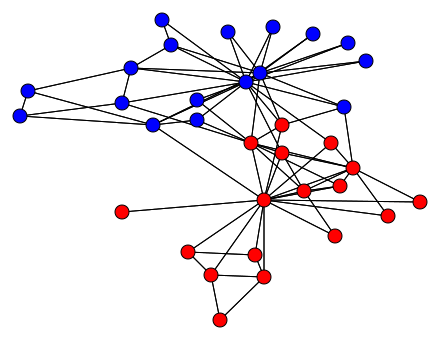

In [9]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with the embedding in dimension 2.
* Check that the embedding weighted by the degrees is centered.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [ ]:
spectral = Spectral(20, barycenter=False, normalized=False, regularization=None)

In [ ]:
spectral.fit(adjacency)

Spectral(n_components=20, normalized_laplacian=True, regularization=None, relative_regularization=True, equalize=False, barycenter=False, normalized=False, solver=LanczosEig(which='LA', maxiter=None, tol=0.0))

In [ ]:
eigenvalues = spectral.eigenvalues_

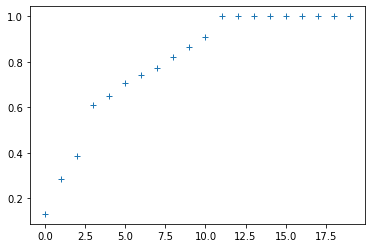

In [ ]:
plt.plot(eigenvalues,linestyle='None',marker='+')

Cela donne des informations sur la structure du graphe. 3 petites eigenvalues donc 3 blocs.

In [ ]:
spectral = Spectral(2, normalized=False)
embedding = spectral.fit_transform(adjacency)
embedding.shape

(34, 2)

In [ ]:
image = svg_graph(adjacency, embedding, labels=labels_true)

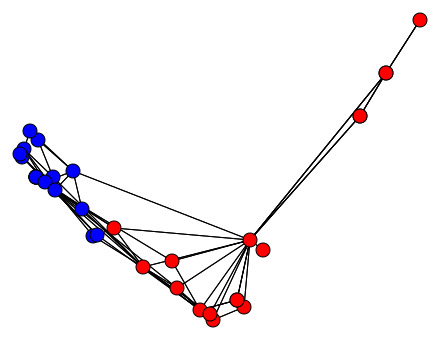

In [ ]:
SVG(image)

In [ ]:
embedding.mean(axis=0)

array([0.00357798, 0.00765447])

In [ ]:
spectral = Spectral(1, normalized=False)
embedding = spectral.fit_transform(adjacency)
embedding.shape

(34, 1)

In [ ]:
embedding[embedding<0]=0
embedding[embedding>0]=1

In [ ]:
misclassified = np.abs(labels_true-embedding.flatten())

In [ ]:
np.argwhere(misclassified==0)

array([[2],
       [8]])

## Openflights


We now consider a larger graph. We use the Laplacian eigenmap in dimension 20. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we work on the embedding in the unit sphere, which can be obtained through the parameter ``normalized`` of the class ``Spectral``.

In [ ]:
graph = openflights

In [ ]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

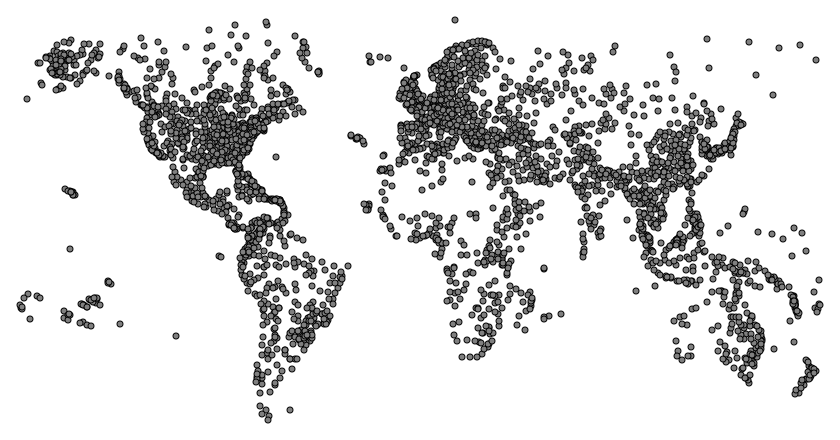

In [ ]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian.
* Display the same world map with the scores equal to the cosine similarity to **Beijing** in the embedding space.
* List the 10 closest airports to **Madrid** in terms of cosine similarity in the embedding space.
* Display the same world map with the 10 clusters found by k-means in the embedding space.<br> **Hint:** Use the class ``KMeans`` with the appropriate embedding.

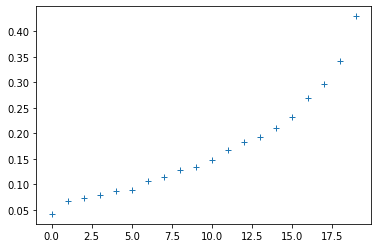

In [ ]:
spectral = Spectral(20)
embedding = spectral.fit_transform(adjacency)
eigenvalues = spectral.eigenvalues_
plt.plot(eigenvalues,linestyle='None',marker='+')

In [ ]:
beijing = 1618

In [ ]:
beijing_vector = embedding[1618]

In [ ]:
res = []
for i in range(len(embedding)):
  a = beijing_vector
  b = embedding[i]
  res.append(np.dot(a,b)/(norm(a)*norm(b)))

res = np.array(res)

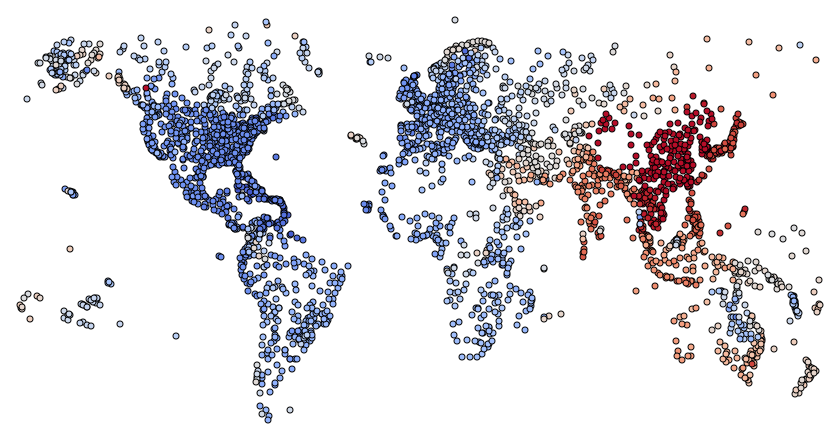

In [ ]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, scores=res)
SVG(image)

In [ ]:
madrid = 572
madrid_vector = embedding[572]

In [ ]:
res_madrid = []
for i in range(len(embedding)):
  a = madrid_vector
  b = embedding[i]
  res_madrid.append(np.dot(a,b)/(norm(a)*norm(b)))

res_madrid = np.array(res_madrid)

In [ ]:
names[np.argsort(-res_madrid)[:10]]

array(['Adolfo Suárez Madrid–Barajas Airport', 'Pamplona Airport',
       'Logroño-Agoncillo Airport', 'A Coruña Airport',
       'San Sebastian Airport', 'Badajoz Airport',
       'Tenerife Norte Airport', 'Manchester Airport',
       'Federico Garcia Lorca Airport', 'Melilla Airport'], dtype='<U65')

In [ ]:
kmeans = KMeans(n_clusters=10)

In [ ]:
labels = kmeans.fit_transform(adjacency)

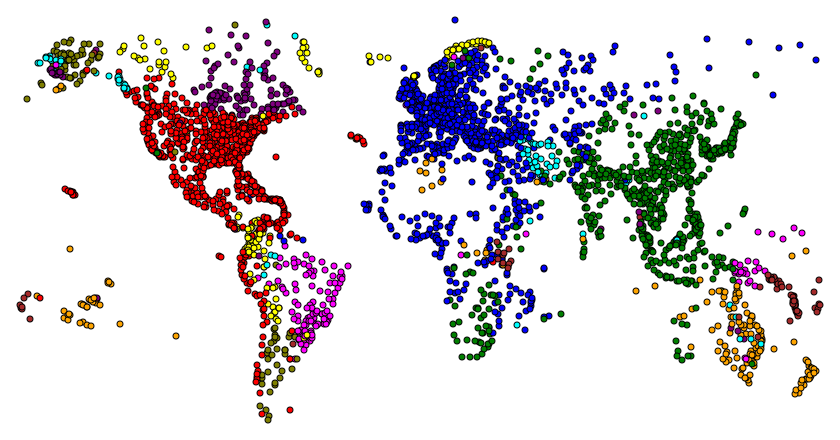

In [ ]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=labels)
SVG(image)

## 2. Digraphs

## Wikipedia Vitals

We now consider a large directed graph. We use the class ``BiSpectral`` (i.e., the directed graph is viewed as a bipartite graph).

In [10]:
graph = wikivitals

In [11]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy

In [20]:
np.argwhere(names_labels=='Geography.Cities.Europe.Northern Europe')

array([[500]])

## To do

* Check that the average cosine similarity between nodes in some set $S$ is given by the square norm of the barycenter of $S$. NOT OK
* Give the average cosine similarity between nodes in the **Mammals** category. OK
* Compare with the expected cosine similarity between two nodes sampled uniformly at random. OK
* Give the average cosine similarity between nodes in some category of your choice. OK 

In [12]:
spectral = BiSpectral(20, solver=HalkoEig(random_state=42))

In [13]:
embedding = spectral.fit_transform(adjacency)

In [ ]:
embedding

array([[-0.08850932,  0.33461655, -0.10783517, ..., -0.37705438,
        -0.1774644 ,  0.05448089],
       [-0.30833903,  0.43425177, -0.05045231, ...,  0.01157508,
        -0.04807118,  0.04338369],
       [-0.30678916,  0.38526343,  0.04631367, ..., -0.29758953,
        -0.07116977,  0.07637652],
       ...,
       [-0.17198243, -0.07754519, -0.07483499, ..., -0.46641771,
         0.04728898,  0.14966788],
       [ 0.35521173, -0.54513214, -0.07667369, ...,  0.00175558,
         0.18635252,  0.11672561],
       [ 0.17107156, -0.3130878 , -0.03606556, ..., -0.39209389,
         0.13117788, -0.00819559]])

In [ ]:
mammal = 274

In [ ]:
names_labels[mammal]

'Biology and health sciences.Organisms.Animals.Mammals'

In [21]:
names_labels[500]

'Geography.Cities.Europe.Northern Europe'

In [23]:
indexes = np.argwhere(labels==500).flatten()

In [56]:
indexes = np.argwhere(labels==274).flatten()

In [57]:
X = [ embedding[i] for i in indexes]

In [58]:
res = 0
count = 0
for i in range(len(indexes)):
  for j in range(len(indexes)):
        a = embedding[indexes[i]]
        b = embedding[indexes[j]]
        res+= np.dot(a,b)/(norm(a)*norm(b))
        count+=1

res=res/count


In [59]:
res

0.9089272843079097

## 3. Bigraphs

## Cinema

Finally, we consider the co-embedding of a large bipartite graph. We use the Laplacian eigenmap in dimension 20.

In [62]:
graph = cinema

In [63]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

## To do

* What is the cosine similarity between **Marion Cotillard** and **The Godfather**  in the embedding space? OK
* What is the cosine similarity between **The Godfather** and **The Godfather 2** in the embedding space? OK

In [64]:
bispectral = BiSpectral(20, regularization=0.5, solver=HalkoEig(random_state=42))

In [65]:
embedding = bispectral.fit(biadjacency)

In [66]:
embedding_row = bispectral.embedding_row_
embedding_row.shape

(88440, 20)

In [67]:
embedding_col = bispectral.embedding_col_
embedding_col.shape



(44586, 20)

In [68]:
cotillard = embedding_col[3814]
godfather = embedding_row[69768]
godfather2 = embedding_row[69770]

In [69]:
np.dot(cotillard,godfather)/(norm(cotillard)*norm(godfather))

0.5280654248065813

In [70]:
np.dot(godfather2,godfather)/(norm(godfather2)*norm(godfather))

0.9465785235963798

In [41]:
cotillard = 3814

In [42]:
actors[cotillard]

'Marion Cotillard'

In [43]:
godfather = 69768
godfather2 = 69770

In [44]:
movies[godfather]

'The Godfather'

In [45]:
movies[godfather2]

'The Godfather Part II'